# 调参技巧

- 更多优化算法
- 激活函数
- 网络初始化
- BN 批归一化
- 数据增强
- 可视化
- fine tuning
- 更多广泛调参技巧

## 更多优化算法
- GD->SGD->mini batch
    - 问题：局部极值 鞍点(saddle point)
- Momentum 栋梁梯度下降
    - 效果：跳出局部极值 鞍点 避免震荡问题
    - 问题：
        - 初始影响大
        - 每一个维度学习率一样 对于稀疏情况 不适用
- Adagrad
    - 思想：自动调整学习率
    - 梯度平方累计值作为学习率衰减系数(sqrt) 
    - 优势：不同方向不同学习率(梯度不同) 自动衰减学习率 
    - 问题：
        - 没有考虑到动量 有局部极值鞍点震荡等问题
        - 前期容易爆炸 后期容易提前停止
            - 所以通常需要很小的初始学习率
        - 系数单调增加
- RMSprop
    - 在衰减系数上使用加权和 防止衰减系数一味增大
    - 像动量法 只是运用到了衰减系数上(sqrt) 
    - 前期问题无法解决 后期问题有效解决
        - 所以通常需要很小的初始学习率
- Adam
    - first_moment = 动量法计算的加权梯度
    - second_moment = rmsprop计算的加权衰减系数(sqrt) 
    - 综合了momentum + rmsprop 优势
        - 前期问题仍然存在
    - 所以通常需要很小的初始学习率
    - 两个加权系数不同 但是通常delta1 = 0.9 delta2 = 0.99 偏向于累计值
    - 校准优化：增大初始速度
        - first_moment/(1-delta1^t)
        - second_moment/(1-delta2^t)
    - learning rate -> 1e-3 5e-4
- 上述所有算法都需要learning rate初始化参数 后三个尤其需要小的初始learning rate  
- 更广泛的自适应算法
    - exp衰减
    - 线性分母衰减
### 总述：
- 稀疏数据由于梯度不均衡 需要使用不同方向不同学习率 使用自适应方法好
- SGD虽然时间更长 但是在合适的初始化 以及学习速度下表现会超过自适应算法
- 自适应算法对于更深 更富啊网络快速收敛很有效 但是最终结果可能会稍差
- Adagrad Rmsprop Adam 本质上类似 Adam更推荐使用

## 激活函数
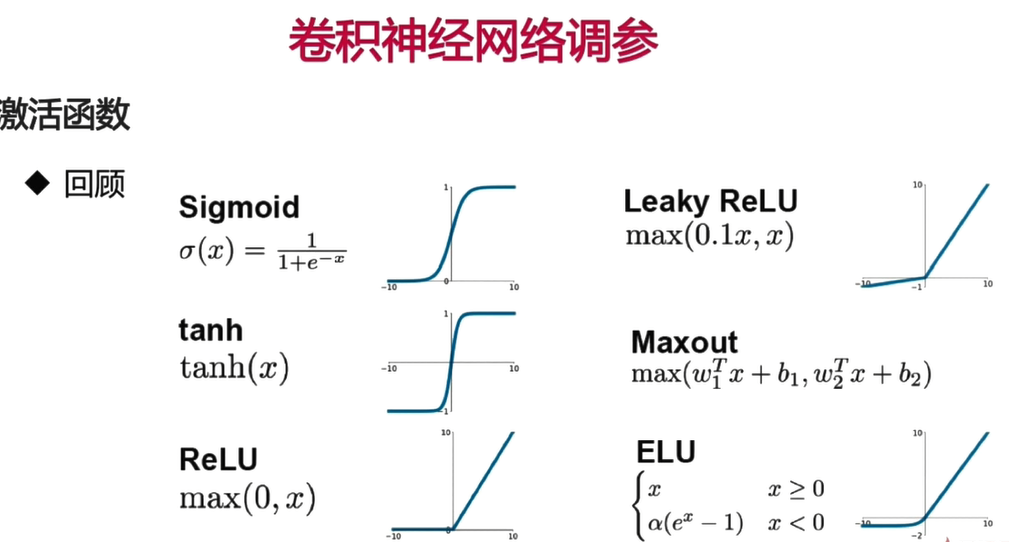

- sigmoid 
    - 问题：
        - 输入输出绝对值大时没有梯度
        - 梯度=(1-f(x))\*f(x) < 1 梯度消失
        - exp计算复杂
        - 均值!=0 及时bn之后还是均值0.5 不利于后续训练
- tanh
    - 问题与优势：
        - 输入输出绝对值大时没有梯度
        - 计算复杂
        - 优势：输出均值为0
- RELU(Rectified Linear Unit)
    - 问题与优势：
        - 不饱和 梯度不会过于小
        - 计算量小
        - 收敛速度快
        - 输出均值不为0 不过在bn后会好一点
        - \>0输入 梯度为1 容易发生爆炸
        - **严重问题** -- Dead ReLU：很大梯度流过 导致参数大变动 输入为<0 不会再有数据激活现象 始终输出为0 梯度始终为0
- 改进relu
    - leaky relu
    - selu
    - 保证<0仍然有梯度 
    - selu相对均值更接近0 但是计算量稍大
- 泛化relu -> MAXOUT
    - 没有dead relu问题
    - 泛化版本
    - 参数double是不好的
### 总述
- relu小心设置learning rate 容易爆炸
- 不要使用sigmoid
- 多实用leaky relu selu 可以尝试maxout
- 可以试试tanh 可能有效 但是希望不大
- 激活函数与初始化 bn密切相关 相互影响 不同activation function对应不同初始化方法

## 网络初始化
- 全部初始化为0
    - 单层网络勉强可以(第一层输入!=0 梯度不会消失) 但不推荐 
    - 多层网络不可以：由于当前输出可能导致后面的输入为0 从而对于一些激活函数可能导致梯度消失(链式法则) 而且深层w参数梯度会变为0 无法更新
- 如何查看初始化结果好坏：
> 查看初始化之后各层的激活函数输出 因为激活函数输出作为下一层输入 激活函数分布均匀意味着下一层输入分布均匀 无偏 从而可以学到更多 如果初始化不当 会导致集中在双侧/0 从而难以学习

- 好的初始化方法举例
    - tanh
        - 太小方差 激活输出集中在0
        - 方差太大 激活输出集中在1 -1
        - Xavier-tanh：
            - w = np.random.randn(fan_in,fan_out)/np.sqrt(fan_in)
        - He-ReLU:
            - w = np.random.randn(fan_in,fan_out)/np.sqrt(fan_in/2)
- 激活函数与初始化 bn密切相关 相互影响 不同activation function对应不同初始化方法

## 批归一化
- 由于初始化 激活函数相互影响 很难调优 而且限制较多
- 批归一化-\> 每一个batch上在每一层输出上做归一化
- 问题：
    - 数据很大时 每个batch本身具有自己的特征 不bn时得到的相当于数据的多个特征的组合 bn之后这种多个特征的特性可能消失 变得一致 归一化可能起了反作用 
- 解决：
    - 反归一化： 归一化后的x记作x' y = beta1\*x'+beta2 (beta1作为归一化权重，beta作为设置的偏置 也可以理解成方差与均值)
- 大多神经网络都会使用 增强学习效果 加快学习速度

## 数据增强
- 归一化
- dropout数据角度理解
- 抽样(alexnet) + 多尺度抽样(VGG)
- 生成数据
    - 翻转 拉伸 缩放 裁剪 变形
    - 色彩变换 ： 对比度 光照
    - 语音领域数据增强 文本序列领域数据增强 需要一定专业知识

## 图像可视化
- 使用tensorboard 可视化工具 包括训练中数据变化图 流图 分布直方图 中间数据图像
- 可视化工具检查中间状态：
    - 损失
    - 梯度
    - 精确度
    - 中间层输出(对于原始数据的抽象)
    - 中间层/激活层输出数据分布
    - 学习率变换

## 更多调参技巧
- 拿到更多数据
- 正则化减少过拟合
- 紧跟进展 使用新方法
- 逐步添加层次 而不是一次训练太深的网络
- 在瓶颈时 增大迭代次数有可能跳出瓶颈
- 使用更多GPU 加速训练

## 更多调参经验
- 首先在标准数据集上进行训练测试结构有效性
- 在小数据上测试 如果过拟合 说明模型有效
- 尽量收集更多数据 生成更多数据 并且保证数据分布平衡
- 每一层的输出分布均匀 激活层输出均值为0 对于网络训练学习很有好处
- 从浅到深 逐步训练 并且浅层/简单网络的结果可以作为初始值 也可以作为复杂网络子结构
- 使用预训练好的稳定模型结构 可以使第三方的 可以是自己的
    - save restore
- fine-tuning 迁移学习
    - 预训练好的网络上进行微调 fiexed一部分 trainable可以指定
    - 由于使用原有参数需要保证网络结构相似性
    - 熟悉tf中对于参数数据的不同格式的读取 导入很重要
    - tf中对于单独参数的文件需要自己搭建相似网络 对于图文件可以直接导入整个计算图
- 可以借助已经有的网络不需要改动 作为应用的组成部分
    - 图像风格转换
    - 文本相关问题中 embedding
    - 图像生成文本问题中图像的编码